In [ ]:
# !pip install tensorflow --upgrade

In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from tensorflow import keras
from keras.layers import Dense, Dropout, Flatten,GlobalAveragePooling2D , Conv2D,Reshape
from keras import Sequential, models, layers
from keras import optimizers
from keras.models import Model
from keras.models import load_model
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import requests

In [ ]:
!pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d ngocquy0708/pbl5-final-dataset-esp32-image

Dataset URL: https://www.kaggle.com/datasets/ngocquy0708/pbl5-final-dataset-esp32-image
License(s): unknown
pbl5-final-dataset-esp32-image.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!ls

Chinsu.jpg  drive    kaggle.json  pbl5-final-dataset-esp32-image.zip  photo306.jpg  TEST
DATA	    Gau.jpg  labels.csv   photo143.jpg			      sample_data


In [ ]:
# extracting the compessed Dataset
from zipfile import ZipFile
dataset = '/content/pbl5-final-dataset-esp32-image.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [ ]:
train_path = "/content/DATA"

In [ ]:
class_folders =  os.listdir(train_path)

image_counts = {}

for class_folder in class_folders:
    path = os.path.join(train_path, class_folder)

    # Count the number of images in the folder
    image_count = len(os.listdir(path))

    # Get the class number from the name directory
    class_number_train = class_folders.index(class_folder)

    # Save the number of images to the dictionary
    image_counts[class_folder] = image_count

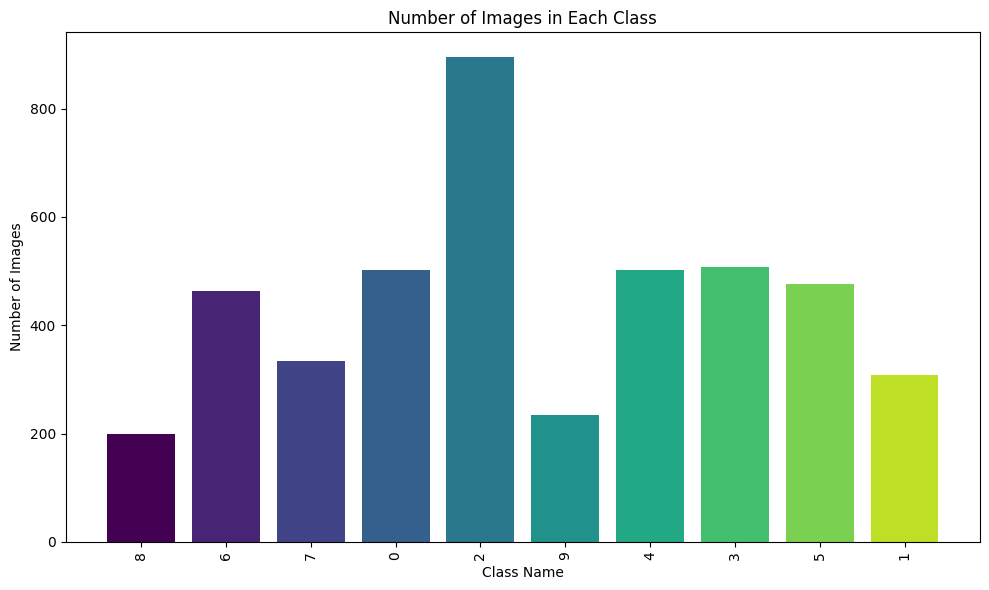

In [ ]:
color_map = cm.viridis

# Create a color array based on the number of photos in each layer
colors = [color_map(i / len(image_counts)) for i in range(len(image_counts))]

# Draw a chart with the created color array
plt.figure(figsize=(10, 6))
bars = plt.bar(image_counts.keys(), image_counts.values(), color=colors)
plt.xlabel('Class Name')
plt.ylabel('Number of Images')
plt.title('Number of Images in Each Class')
plt.xticks(rotation=90)
plt.tight_layout()

plt.show()

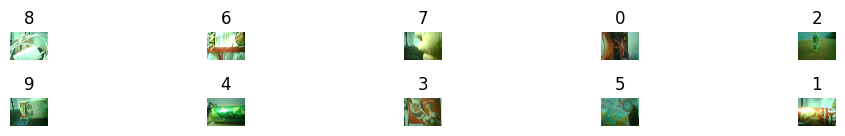

In [ ]:
plt.figure(figsize=(10, 10))

# Loop through each subfolder
for i, folder in enumerate(class_folders):
    path = os.path.join(train_path, folder)

    # Set subplot index
    plt.subplot(15, 5, i+1)

    # Loop through each file in the directory
    for j, img in enumerate(os.listdir(path)):
        # Make sure to display only a single image per folder
        if j >= 1:
            break

        img_array = cv2.imread(os.path.join(path,img))

        # Show image
        plt.imshow(cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB))
        plt.title(folder)
        plt.axis('off')

# Set space between rows and columns
plt.subplots_adjust(hspace=5, wspace=0.5)
plt.tight_layout()
plt.show()

In [ ]:
path_label = '/content/labels.csv'

df = pd.read_csv(path_label)

In [ ]:
df

,ClassId,Name
0,0,Chin-su
1,1,Coca
2,2,Tea-plus
3,3,Cafe
4,4,7-up
5,5,Snack
6,6,Mi Tom
7,7,Gau Bong
8,8,Sac Dien Thoai
9,9,Bo Bai


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   ClassId  10 non-null     int64 
 1   Name     10 non-null     object
dtypes: int64(1), object(1)
memory usage: 288.0+ bytes


In [ ]:
class_label = len(df)

In [ ]:
print('The number of labels is : ',class_label)

The number of labels is :  10


In [ ]:
import tensorflow as tf

In [ ]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                  rotation_range=10,
                                                                  width_shift_range=0.1,
                                                                  height_shift_range=0.1,
                                                                  shear_range=0.15,
                                                                  zoom_range=0.15,
                                                                  horizontal_flip=False,
                                                                  vertical_flip=False,
                                                                  fill_mode='nearest',
                                                                  validation_split=0.2,
                                                                  )

In [ ]:
train_images = train_generator.flow_from_directory(train_path,
                                                   target_size=(128, 128),
                                                   class_mode='categorical',
                                                   batch_size=32,
                                                   color_mode='rgb',
                                                   subset='training'
                                                  )

val_images = train_generator.flow_from_directory(train_path,
                                                 target_size=(128, 128),
                                                 class_mode='categorical',
                                                 batch_size=32,
                                                 color_mode='rgb',
                                                 subset='validation'
                                                )

Found 3546 images belonging to 10 classes.
Found 881 images belonging to 10 classes.


In [ ]:
# View the structure of the train_images object
print(train_images.class_indices)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9}


In [ ]:
# from tensorflow.keras.models import Model, Sequential
# from tensorflow.keras.layers import Conv2D, Dropout, MaxPool2D, Flatten, Dense
# from tensorflow.keras.optimizers import Adam

In [ ]:

def identity_block(input_tensor, kernel_size, filters, stage, block):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.BatchNormalization(name=bn_name_base + '2a')(input_tensor)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters1, (1, 1), kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(x)

    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)

    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)

    x = layers.add([x, input_tensor])

    return x

In [ ]:
def conv_block(input_tensor,
               kernel_size,
               filters,
               stage,
               block,
               strides=(2, 2)):
    filters1, filters2, filters3 = filters
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    x = layers.BatchNormalization(name=bn_name_base + '2a')(input_tensor)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters1, (1, 1), strides=strides, kernel_initializer='he_normal',
                      name=conv_name_base + '2a')(x)

    x = layers.BatchNormalization(name=bn_name_base + '2b')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters2, kernel_size, padding='same',
                      kernel_initializer='he_normal',
                      name=conv_name_base + '2b')(x)

    x = layers.BatchNormalization(name=bn_name_base + '2c')(x)
    x = layers.Activation('relu')(x)
    x = layers.Conv2D(filters3, (1, 1), kernel_initializer='he_normal',
                      name=conv_name_base + '2c')(x)

    shortcut = layers.Conv2D(filters3, (1, 1), strides=strides,
                             kernel_initializer='he_normal',
                             name=conv_name_base + '1')(input_tensor)
    shortcut = layers.BatchNormalization(name=bn_name_base + '1')(shortcut)

    x = layers.add([x, shortcut])

    return x

In [ ]:
def ResNet152(input_shape=(128, 128, 3), classes=10):
    img_input = layers.Input(shape=input_shape)

    x = layers.ZeroPadding2D(padding=(3, 3), name='conv1_pad')(img_input)
    x = layers.Conv2D(64, (7, 7),
                      strides=(2, 2),
                      padding='valid',
                      kernel_initializer='he_normal',
                      name='conv1')(x)
    x = layers.BatchNormalization(name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.ZeroPadding2D(padding=(1, 1), name='pool1_pad')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)

    x = conv_block(x, 3, [64, 64, 256], stage=2, block='a', strides=(1, 1))
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='b')
    x = identity_block(x, 3, [64, 64, 256], stage=2, block='c')

    x = conv_block(x, 3, [128, 128, 512], stage=3, block='a')
    for i in range(7):
        x = identity_block(x, 3, [128, 128, 512], stage=3, block='b' + str(i))

    x = conv_block(x, 3, [256, 256, 1024], stage=4, block='a')
    for i in range(35):  # 1 conv_block + 35 identity_blocks = 36 blocks
        x = identity_block(x, 3, [256, 256, 1024], stage=4, block='b' + str(i))

    x = conv_block(x, 3, [512, 512, 2048], stage=5, block='a')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='b')
    x = identity_block(x, 3, [512, 512, 2048], stage=5, block='c')

    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    # x = Dense(2048, activation='relu')(x)  # Added dense layer to make shape compatible
    # x = Reshape((32, 32, 2))(x)  # Reshape to allow Conv2D operation
    # x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    # x = Flatten()(x)
    # x = Dense(512, activation='relu')(x)
    # x = Dense(128, activation='relu')(x)
    x = layers.Dense(classes, activation='softmax', name='fc1000')(x)

    # Create model.
    model = Model(img_input, x, name='resnet152')

    return model

# Test the model
model = ResNet152()
model.summary()

Model: "resnet152"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 134, 134, 3)          0         ['input_3[0][0]']             
                                                                                                  
 conv1 (Conv2D)              (None, 64, 64, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 bn_conv1 (BatchNormalizati  (None, 64, 64, 64)           256       ['conv1[0][0]']               
 on)                                                                                      

In [ ]:
# Define a Callback class that stops training once accuracy reaches 99.9%
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.99):
      print("\nReached 99.9% accuracy so cancelling training!")
      self.model.stop_training = True

In [ ]:
from keras.callbacks import ReduceLROnPlateau
#Callback to save the best model. Using checkpoint and earlystopping to monitor validation accuracy
callbacks_list = [
    tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_accuracy', factor=0.1, patience=10, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(
        filepath='/content/drive/MyDrive/PBL5/PBL5.keras',
        monitor='val_accuracy', save_best_only=True, verbose=1),
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=10,verbose=1)
]

In [ ]:
optimizer = Adam(learning_rate=0.0001,  # Learning speed
                beta_1=0.9,             # Beta coefficient1
                beta_2=0.999,           # Beta coefficient2
                )

In [ ]:
model.compile(optimizer=optimizer,
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [ ]:
callbacks =myCallback()

In [ ]:
print('----------------------------Model is being built......................\n')
history = model.fit(train_images,
                    epochs=20,
                    validation_data=val_images,
                    verbose=1,
                    callbacks=[callbacks]
                   )
print('\n----------------------------Model completed......................\n')

----------------------------Model is being built......................

Epoch 1/20
111/111 [==============================] - 178s 665ms/step - loss: 0.8780 - accuracy: 0.7496 - val_loss: 2.1701 - val_accuracy: 0.2747
Epoch 2/20
111/111 [==============================] - 70s 633ms/step - loss: 0.3223 - accuracy: 0.8982 - val_loss: 2.7501 - val_accuracy: 0.2997
Epoch 3/20
111/111 [==============================] - 71s 639ms/step - loss: 0.2016 - accuracy: 0.9388 - val_loss: 1.2744 - val_accuracy: 0.6198
Epoch 4/20
111/111 [==============================] - 78s 705ms/step - loss: 0.2064 - accuracy: 0.9374 - val_loss: 1.1357 - val_accuracy: 0.7798
Epoch 5/20
111/111 [==============================] - 70s 634ms/step - loss: 0.1438 - accuracy: 0.9540 - val_loss: 0.7194 - val_accuracy: 0.7980
Epoch 6/20
111/111 [==============================] - 73s 653ms/step - loss: 0.1115 - accuracy: 0.9701 - val_loss: 0.4769 - val_accuracy: 0.8831
Epoch 7/20
111/111 [==============================] - 71s

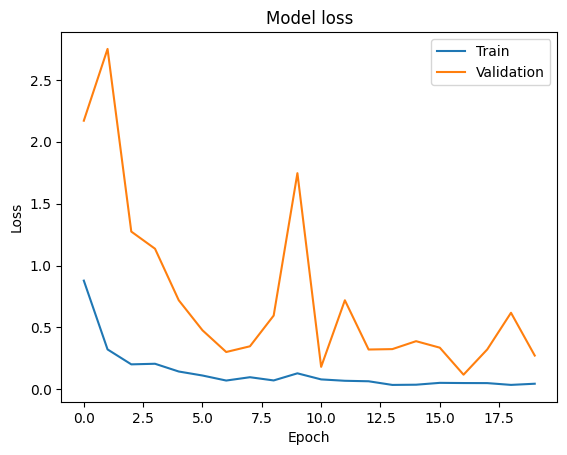

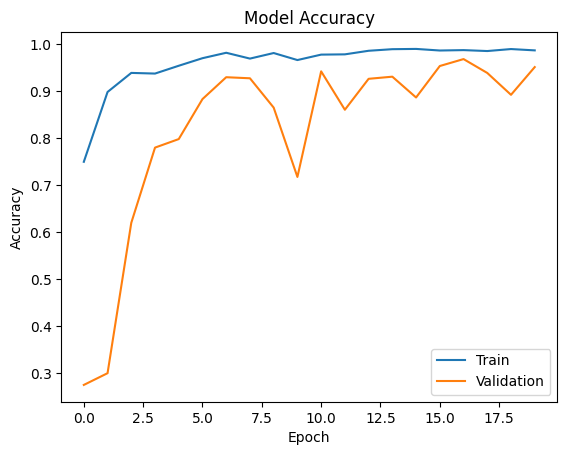

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


# Plot the accuracy of training and validation
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

In [ ]:
model.save("/content/drive/MyDrive/PBL5_MODEL/Model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
from tensorflow.keras.models import load_model

# Tải mô hình đã huấn luyện
model = load_model('/content/drive/MyDrive/PBL5_MODEL/Model.h5')

In [ ]:
directory_test = "/content/TEST"

In [ ]:
classes_for_predict = {0:'Chin-su',1:'Coca',2:'Tea-plus',3:'Cafe',4:'7-up',5:'Snack',6:'Mi Tom',7:'Gau Bong',8:'Sac Dien Thoai',9:'Bo Bai'}

In [ ]:
classes_map = {
    '0': 0,
    '1': 1,
    '2': 2,
    '3': 3,
    '4': 4,
    '5': 5,
    '6': 6,
    '7': 7,
    '8': 8,
    '9': 9
}

In [ ]:
class_name_test = os.listdir(directory_test)

X_test = []
Y_test = []

for class_number_train, class_name in enumerate(class_name_test):
    path = os.path.join(directory_test, class_name)
    for img in os.listdir(path):
        # Đọc ảnh
        img_array = cv2.imread(os.path.join(path, img))
        img_array = cv2.cvtColor(img_array, cv2.COLOR_BGR2RGB)
        img_array = cv2.resize(img_array, (128, 128))
        X_test.append(img_array)
        Y_test.append(classes_map[class_name])

array([[[112, 188, 165],
        [142, 222, 193],
        [149, 227, 201],
        ...,
        [ 73, 146, 124],
        [ 80, 146, 117],
        [ 69, 144, 122]],

       [[117, 186, 166],
        [148, 228, 196],
        [150, 233, 200],
        ...,
        [ 86, 150, 126],
        [ 76, 147, 123],
        [ 81, 146, 111]],

       [[116, 188, 165],
        [137, 217, 190],
        [152, 232, 204],
        ...,
        [ 88, 150, 126],
        [ 83, 152, 124],
        [ 73, 151, 127]],

       ...,

       [[115, 175, 138],
        [ 94, 113,  68],
        [ 87, 101,  75],
        ...,
        [177, 253, 196],
        [140, 186, 137],
        [117, 170, 118]],

       [[118, 165, 130],
        [ 93, 114,  77],
        [ 81, 107,  78],
        ...,
        [163, 220, 170],
        [123, 176, 134],
        [116, 166, 127]],

       [[113, 161, 138],
        [ 86, 124,  78],
        [ 82, 116,  63],
        ...,
        [143, 195, 145],
        [122, 169, 138],
        [116, 157, 114]]], dtype=uint8)
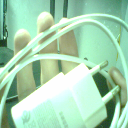

In [ ]:
X_test[0]

In [ ]:
print('Number of test data : ', len(X_test))

Number of test data :  1262


In [ ]:
No_test = len(X_test)
No_train = train_images.samples
No_val = val_images.samples

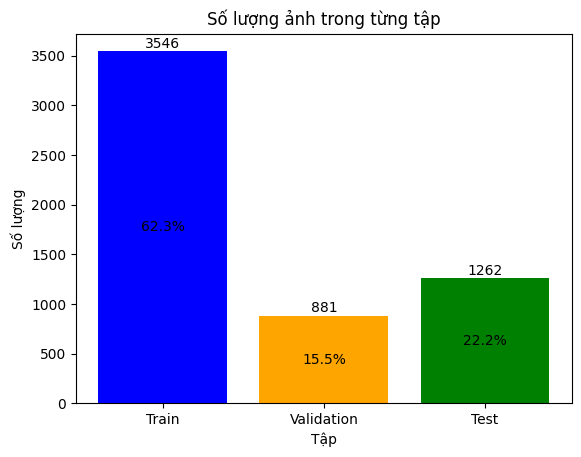

In [ ]:
categories = ['Train', 'Validation', 'Test']
values = [No_train, No_val, No_test]
total = sum(values)
colors = ['blue', 'orange', 'green']
bars = plt.bar(categories, values, color=colors)

plt.title('Số lượng ảnh trong từng tập')
plt.xlabel('Tập')
plt.ylabel('Số lượng')

for bar in bars:
    yval = bar.get_height()
    percent = yval / total * 100
    plt.text(bar.get_x() + bar.get_width()/2, yval / 2, f'{percent:.1f}%', ha='center', va='center')
    plt.text(bar.get_x() + bar.get_width()/2, yval + 5, yval, ha='center', va='bottom')

plt.show()

In [ ]:
X_test=np.array(X_test)
X_test=X_test /255.0

Actual :  Mi Tom
1/1 [==============================] - 3s 3s/step
Predicted :  Mi Tom


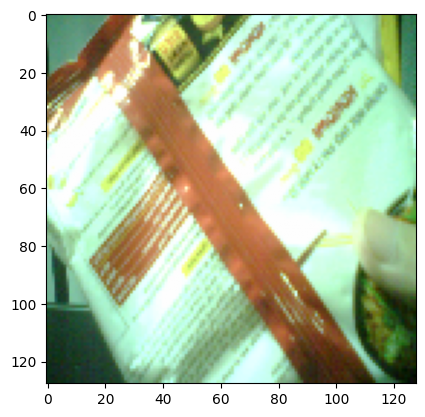

In [ ]:
print('Actual : ', classes_for_predict[int(Y_test[151])])
plt.imshow(X_test[150])

predictions = model.predict(np.expand_dims(X_test[151], axis=0))
predicted_classes = np.argmax(predictions, axis=1)
print('Predicted : ', classes_for_predict[predicted_classes[0]])

In [ ]:
lb = LabelBinarizer()
Y_test= lb.fit_transform(Y_test)

In [ ]:
from sklearn.metrics import classification_report

# Make predictions
predictions = model.predict(X_test)

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = np.argmax(Y_test, axis=1)

# Get class labels
class_labels = class_name_test

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)# Giả sử y_true và y_pred là nhãn thực và nhãn dự đoán của bạn, tương ứng

print(report)

40/40 [==============================] - 3s 86ms/step
              precision    recall  f1-score   support

           8       1.00      0.80      0.89       127
           6       0.99      1.00      0.99        96
           7       1.00      1.00      1.00       264
           0       1.00      0.84      0.91       144
           2       0.85      0.97      0.91       120
           9       0.85      1.00      0.92       139
           4       0.77      1.00      0.87       132
           3       1.00      0.92      0.96       108
           5       0.95      0.60      0.73        60
           1       1.00      0.99      0.99        72

    accuracy                           0.93      1262
   macro avg       0.94      0.91      0.92      1262
weighted avg       0.94      0.93      0.93      1262



In [ ]:

img = cv2.imread('/SacDT.jpg')
img = cv2.resize(img, (128,128))
img = np.array(img)
img = np.expand_dims(img, axis=0)
img = img/255
predictions = model.predict(img)
print(f"Predictions: {predictions}")
predicted_class = predictions.argmax()
print(f"Predicted class: {classes_for_predict[predicted_class]}")

1/1 [==============================] - 0s 105ms/step
Predictions: [[1.8258296e-09 8.7340395e-12 5.6634873e-17 5.8713897e-12 6.4075110e-08
  7.7492302e-08 7.9201482e-02 2.5245045e-10 9.2079842e-01 2.0938197e-12]]
Predicted class: Sac Dien Thoai


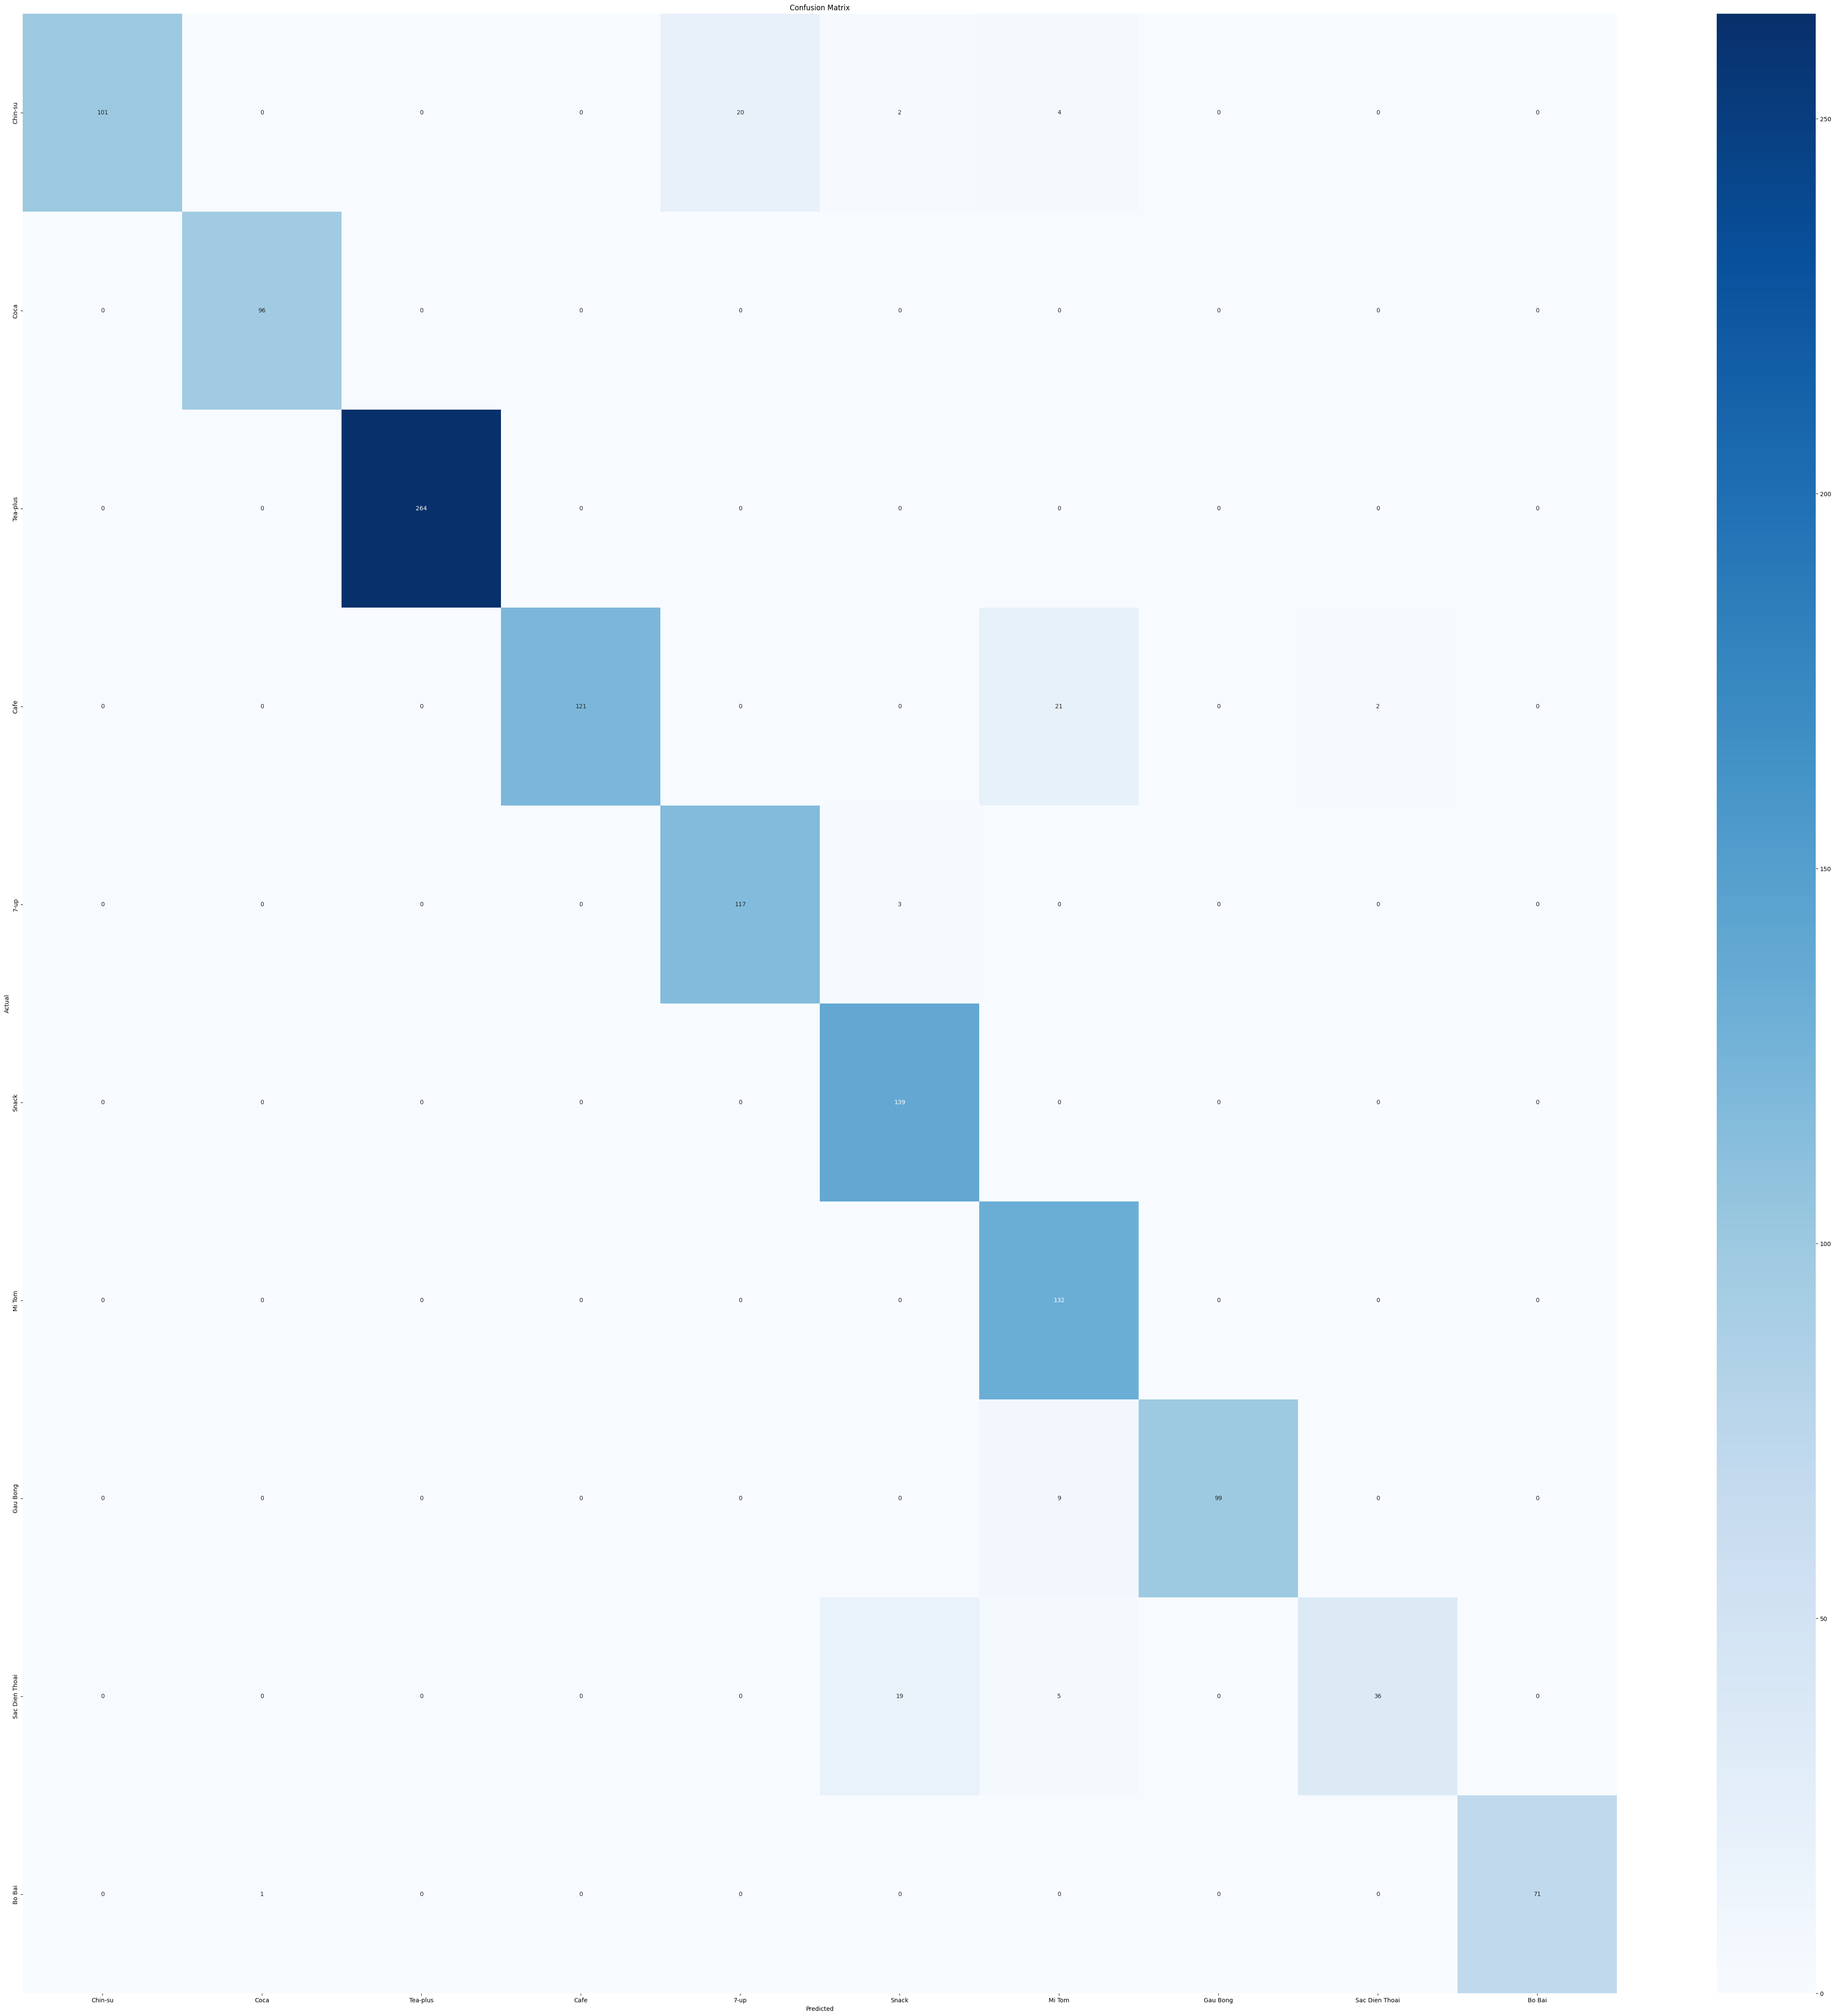

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class_labels = list(classes_for_predict.values())

# Calculate confusion matrix
confusion_df = pd.crosstab(true_classes, predicted_classes, rownames=['Actual'], colnames=['Predicted'])

# Plot confusion matrix
plt.figure(figsize=(60, 60))
sns.heatmap(confusion_df, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()